# Building Decision Tree from scratch


### Importing Necessary Libraries

In [2]:
from math import log,floor
import pandas as pd
import sys
from graphviz import Digraph
import seaborn as sns
import matplotlib.pyplot as plt
nodeId=1

### Function to calculate Entropy

In [3]:
def entropy(list1,n):
    set1=set(list1)
    total_count=len(list1)
    entropy=0
    
    for ele in set1:
        p=(list1.count(ele)/total_count)
        entropy+=(-1)*p*log(p,n) 
    return entropy

### Function to calculate average entropy

In [4]:
def average_entropy(df,column,target,n,attribute='categorical',weight=0):
    list1=list(df[column])
    total_count=len(list1)
    ave_ent=0
    if attribute=='categorical':
        set1=set(list1)
        for ele in set1:
            p=(list1.count(ele)/total_count)
            ave_ent+=p*entropy(list(df[df[column]==ele][target]),n)
    elif attribute=='continuous':
        prob_LTE=sum([item<=weight for item in list1])/total_count
        prob_GT=sum([item>weight for item in list1])/total_count
        ave_ent=prob_LTE*entropy(list(df[df[column]<=weight][target]),n)+prob_GT*entropy(list(df[df[column]>weight][target]),n)
    else:
        raise Exception("Attribute Dictionary i.e. attr_dict has some unknown category for : {}".format(column))
    return ave_ent
    

### Function to calculate gain of any child node

In [5]:
def gain(parent_entropy,child_ave_entropy):
    return (parent_entropy-child_ave_entropy)

### Function to calculate gain ratio of any node

In [6]:
def gain_ratio(gain,df,column,n,attribute='categorical',weight=0):
    list1=list(df[column])
    total_count=len(list1)
    int_info=0
    if attribute=='categorical':
        set1=set(list1)
        for ele in set1:
            p=(list1.count(ele)/total_count)
            int_info+=(-1)*p*log(p,n)
    elif attribute=='continuous':
        prob_LTE=sum([item<=weight for item in list1])/total_count
        prob_GT=sum([item>weight for item in list1])/total_count
        if prob_LTE>0 and prob_GT>0:
            int_info=(-1)*(prob_LTE*log(prob_LTE,n)+prob_GT*log(prob_GT,n))
        else:
            int_info=0#float('inf')
    else:
        raise Exception("Attribute Dictionary i.e. attr_dict has some unknown category for : {}".format(column))
    if int_info==0:
        return float('inf')
    else:
        return gain/int_info

### Creating class Node which will be used to create nodes for our tree

In [7]:
class Node:
    def __init__(self,df,cargo,target,classes,parent_node=None,parent_branch_name=None,attribute='categorical',weight=0):
        global nodeId
        self.cargo = cargo
        self.branches={}
        self.probability={}
        self.parent_node=parent_node
        self.parent_branch=parent_branch_name
        self.attribute=attribute
        self.weight=weight
        self.id=nodeId
        nodeId=nodeId+1
        self.branchCount={}
        self.accuracy={}
        if attribute=='categorical':
            set1=set(df[cargo])
            for branch in set1:
                self.branches[branch]=None
                self.probability[branch]=self.calc_probability(list(df[df[cargo]==branch][target]),classes)
                self.branchCount[branch]=sum(df[cargo]==branch)
                self.accuracy[branch]={'right':0,'wrong':0}
        elif attribute=='continuous':
            set1=[]
            if sum(df[cargo]<=weight)>0:set1.append('<=')
            if sum(df[cargo]>weight)>0:set1.append('>')
            for branch in set1:
                self.branches[branch]=None
                if branch=='<=':
                    self.probability[branch]=self.calc_probability(list(df[df[cargo]<=weight][target]),classes)
                    self.branchCount[branch]=sum(df[cargo]<=weight)
                elif branch=='>':
                    self.probability[branch]=self.calc_probability(list(df[df[cargo]>weight][target]),classes)
                    self.branchCount[branch]=sum(df[cargo]>weight)
                self.accuracy[branch]={'right':0,'wrong':0}
        else:
            raise Exception("Attribute Dictionary i.e. attr_dict has some unknown category for : {}".format(cargo))
        
    
    
    #This function will calculate the probability of all the prediction classes at each branch
    #This function sets the value of 'probability' attribute of class 'Node'
    #this function returns a dictionary where key of the dictionary is prediction classes
    #and value of the dictionary is probability
    def calc_probability(self,target_list,classes):
        prob_dict={}
        for class_ele in classes:
            prob_dict[class_ele]=target_list.count(class_ele)/len(target_list)
        return prob_dict
    
    
    
    #This function will perform the pruning procedure i.e. 
    #reset_accuracy of each node, finding_leafnodes of the tree, find the leafnodes which are eligible for cutting 
    #and finally cut the cuttable nodes
    def pruning(self,df_test,df_target):
        if type(df_test)!=type(pd.DataFrame()):
            raise Exception("df_test should be of type Pandas Dataframe.")
        if type(df_target)!=type(pd.DataFrame()):
            raise Exception("df_target should be of type Pandas Dataframe.")
        
        self.reset_accuracy()
        for ((index1,test_row),(index2,target_row)) in zip(df_test.iterrows(),df_target.iterrows()):
            self.set_accuracy(test_row,target_row)
        leafnodes=self.find_leafnodes()
        cuttable_nodes=self.find_cuttable_nodes(leafnodes)
        while len(cuttable_nodes)>0:
            self.cut_nodes(cuttable_nodes)
            cuttable_nodes=self.find_cuttable_nodes(self.find_leafnodes())
    
    
    
    #This function is part of the pruning process
    #This function cuts the leaf nodes
    def cut_nodes(self,cuttable_nodes):
        for node in cuttable_nodes:
            print("Cutting: "+"'ID: "+str(node.id)+" - "+node.cargo+"' Node")
            node.parent_node.branches[node.parent_branch]=None
            
    
    
    #This function is part of the pruning process
    #This function finds the leaf nodes
    def find_leafnodes(self):
        leafnodes=[]
        branch_found=0
        for branch in self.branches.keys():
            if self.branches[branch]!=None:
                leafnodes=[*leafnodes,*self.branches[branch].find_leafnodes()]
                branch_found=1
        if branch_found==0:
            leafnodes=[self]
        return leafnodes
    
    
    
    #This function is part of the pruning process
    #This function finds the leafnodes which are eligible for cutting
    def find_cuttable_nodes(self,leafnodes):
        cuttable_nodes=[]
        for node in leafnodes:
            sum_of_w_vals=0
            for branch in node.accuracy.keys():
                sum_of_w_vals+=node.accuracy[branch]['wrong']
            if sum_of_w_vals>=node.parent_node.accuracy[node.parent_branch]['wrong']:
                cuttable_nodes.append(node)
        return cuttable_nodes
            
            
            
    #This function resets the accuracy(i.e. right=0 and wrong=0) of each branch to 0
    #This function resets the 'accuracy' attribute of the class 'Node'
    def reset_accuracy(self):
        for branch in self.branches.keys():
            self.accuracy[branch]['right']=0
            self.accuracy[branch]['wrong']=0
            if self.branches[branch]!=None:
                self.branches[branch].reset_accuracy()
        
    
    
    #This function simulates the test data through the tree created
    #And then sets the accuracy counts for each branch i.e. right=? and wrong=?
    #This function sets the 'accuracy' attribute of the class 'Node'
    def set_accuracy(self,test_row,target_row):
        match_found=0
        result=None
        if self.attribute=='categorical':
            for branch in self.branches.keys():
                if branch==test_row[self.cargo]:
                    match_found=1
                    result=max(self.probability[branch].keys(),key=lambda x:self.probability[branch][x])
                    if result==target_row[target_row.index[0]]:
                        self.accuracy[branch]['right']+=1
                    else:
                        self.accuracy[branch]['wrong']+=1    
                    if self.branches[branch]!=None:
                        self.branches[branch].set_accuracy(test_row,target_row)
                        
        elif self.attribute=='continuous':
            match_found=1
            if test_row[self.cargo]<=self.weight:
                branch='<='
            else:
                branch='>'
            result=max(self.probability[branch].keys(),key=lambda x:self.probability[branch][x])
            
            if result==target_row[target_row.index[0]]:
                self.accuracy[branch]['right']+=1
            else:
                self.accuracy[branch]['wrong']+=1
                
            if self.branches[branch]!=None:
                self.branches[branch].set_accuracy(test_row,target_row)
            
        if match_found==0:
            max_loc_branch=max(self.branchCount.keys(),key=lambda x:self.branchCount[x])
            result=max(self.probability[max_loc_branch].keys(),key=lambda x:self.probability[max_loc_branch][x])
            if result==target_row[target_row.index[0]]:
                self.accuracy[max_loc_branch]['right']+=1
            else:
                self.accuracy[max_loc_branch]['wrong']+=1
                
            if self.branches[max_loc_branch]!=None:
                self.branches[max_loc_branch].set_accuracy(test_row,target_row)
    
    
    
    #This function is used for prediction    
    def predict(self,df):
        if type(df)!=type(pd.DataFrame()):
            raise Exception("df should be of type Pandas Dataframe.")
        predictions=[self.dig(row) for index,row in df.iterrows()]
        return predictions
            
    #This function is part of the predition procedure and digs down the tree according to the data 
    #provided by the 'predict' function and returns the final match found
    def dig(self,row):
        match_found=0
        result=None
        if self.attribute=='categorical':
            for branch in self.branches.keys():
                if branch==row[self.cargo]:
                    match_found=1
                    if self.branches[branch]!=None:
                        result=self.branches[branch].dig(row)
                        break
                    else:
                        result=max(self.probability[branch].keys(),key=lambda x:self.probability[branch][x])
                        break
        elif self.attribute=='continuous':
            match_found=1
            if row[self.cargo]<=self.weight:
                branch='<='
            else:
                branch='>'
            if self.branches[branch]!=None:
                result=self.branches[branch].dig(row)
            else:
                result=max(self.probability[branch].keys(),key=lambda x:self.probability[branch][x])
            
            
        if match_found==0:
            max_loc_branch=max(self.branchCount.keys(),key=lambda x:self.branchCount[x])
            if self.branches[max_loc_branch]!=None:
                result=self.branches[max_loc_branch].dig(row)
            else:
                result=max(self.probability[max_loc_branch].keys(),key=lambda x:self.probability[max_loc_branch][x])
                
        return result

### Function which decides the attribute column having the highest priority to be selected for being created as a Node

In [8]:
def calculate_cargo_name(parent_entropy,df_rest,training_cols_rest,target_col,n,attr_dict):
    col_n_ga={}
    attribute=''
    for col in training_cols_rest:
        try:
            attribute=attr_dict[col]
        except KeyError:
            print("You haven't specified any attribute for '{}' in attr_dict.\n\
Please specify whether '{}' is categorical or continuous.\nExample:\n\t'{}' :'categorical'\nor\n\t'{}' :'continuous'\n\n\n\n\n".format(col,col,col,col))
            sys.exit(1)
        if attribute=='categorical':
            ga=gain(parent_entropy,average_entropy(df_rest,col,target_col,n,attribute,0))
            ga_rat=gain_ratio(ga,df_rest,col,n)
            col_n_ga[col]=[ga_rat,0]
        elif attribute=='continuous':
            final_weight_cont=0
            final_ga_rat_cont=0
            final_ga_cont=0
            cont_col_list=list(df_rest[col])
            cont_col_list.sort()
            for i in range(len(cont_col_list)-1):
                weight=floor((cont_col_list[i]+cont_col_list[i+1])/2)
                ga=gain(parent_entropy,average_entropy(df_rest,col,target_col,n,attribute,weight))
                if final_ga_cont<ga:
                    final_ga_cont=ga
                    final_ga_rat_cont=gain_ratio(ga,df_rest,col,n,attribute,weight)
                    final_weight_cont=weight
            col_n_ga[col]=[final_ga_rat_cont,final_weight_cont]
        else:
            raise Exception("Attribute Dictionary i.e. attr_dict has some unknown category for : '{}'\n\
Note: An attribute like '{}' can be either '{}' :'categorical' or '{}' :'continuous'".format(col,col,col,col))
    cargo_max=max(col_n_ga.keys(),key=lambda x:col_n_ga[x][0])
    return cargo_max,col_n_ga[cargo_max][1]

### Function which initiates and controls the creation of tree nodes

In [9]:
def make_new_tree(parent_entropy,df_rest,training_cols_rest,target_col,n,classes_list,max_prob,attr_dict,parent_node=None,parent_branch_name=None):
    node1=None
    
    if max_prob==1:
        node1=None
    elif len(training_cols_rest)==0:
        node1=None
    elif len(df_rest)==0:
        node1=None
    else:
        (cargo,weight)=calculate_cargo_name(parent_entropy,df_rest,training_cols_rest,target_col,n,attr_dict)
        node1=Node(df_rest,cargo,target_col,classes_list,parent_node,parent_branch_name,attr_dict[cargo],weight)
        for branch in node1.branches.keys():    
            if branch=='<=' and attr_dict[cargo]=='continuous':
                parent_entropy_new=entropy(list(df_rest[df_rest[cargo]<=weight][target_col]),n)
                df_rest_new=df_rest[df_rest[cargo]<=weight]
            elif branch=='>' and attr_dict[cargo]=='continuous': 
                parent_entropy_new=entropy(list(df_rest[df_rest[cargo]>weight][target_col]),n)
                df_rest_new=df_rest[df_rest[cargo]>weight]
            elif attr_dict[cargo]=='categorical': 
                parent_entropy_new=entropy(list(df_rest[df_rest[cargo]==branch][target_col]),n)
                df_rest_new=df_rest[df_rest[cargo]==branch]
            else:
                raise Exception("Attribute Dictionary i.e. attr_dict has some unknown category for : {}".format(cargo))
                
            training_cols_rest_new=[col for col in training_cols_rest if col!=cargo]
            max_prob_curr_branch=node1.probability[branch][max(node1.probability[branch].keys(),key=lambda x:node1.probability[branch][x])]
            node1.branches[branch]=make_new_tree(parent_entropy_new,
                                                 df_rest_new,
                                                training_cols_rest_new,
                                                target_col,
                                                n,
                                                classes_list,
                                                max_prob_curr_branch,
                                                attr_dict,
                                                node1,
                                                branch)
    return node1


### Function to visualize the tree

In [10]:
def show_tree(n,branch='',dot = Digraph(comment='My Tree',node_attr={'color': 'lightblue2', 'style': 'filled'}),p_max_id=0):
    if(n.parent_node!=None):
        dot.node(str(n.id)+str(n.cargo),"ID: "+str(n.id)+" - "+str(n.cargo))
        dot.node(str(n.parent_node.id)+str(n.parent_node.cargo),"ID: "+str(n.parent_node.id)+" - "+str(n.parent_node.cargo))
        if n.parent_node.attribute=='categorical':
            dot.edge(str(n.parent_node.id)+str(n.parent_node.cargo),str(n.id)+str(n.cargo),"["+str(branch)+" : R= "+str(n.parent_node.accuracy[branch]['right'])+" : W= "+str(n.parent_node.accuracy[branch]['wrong'])+"]")
        else:
            dot.edge(str(n.parent_node.id)+str(n.parent_node.cargo),str(n.id)+str(n.cargo),"["+str(branch)+str(n.parent_node.weight)+" : R= "+str(n.parent_node.accuracy[branch]['right'])+" : W= "+str(n.parent_node.accuracy[branch]['wrong'])+"]")
    for branch in n.branches.keys():
        if n.branches[branch]!=None:
            dot,p_max_id=show_tree(n.branches[branch],branch,dot,p_max_id)
        else:
            p_max_id+=1
            p_max=str(max(n.probability[branch].keys(),key=lambda x:n.probability[branch][x]))
            dot.node(str(p_max_id),p_max)
            if n.attribute=='categorical':
                dot.edge(str(n.id)+str(n.cargo),str(p_max_id),"["+str(branch)+" : R= "+str(n.accuracy[branch]['right'])+" : W= "+str(n.accuracy[branch]['wrong'])+"]")
            else:
                dot.edge(str(n.id)+str(n.cargo),str(p_max_id),"["+str(branch)+str(n.weight)+" : R= "+str(n.accuracy[branch]['right'])+" : W= "+str(n.accuracy[branch]['wrong'])+"]")
    
    return dot,p_max_id
            
    

### Function to build Confusion Matrix

In [11]:
def plot_confusion_matrix(actual_target_list,predicted_target_list,classes_list):
    conf_mat=[]
    actual_target_list=list(actual_target_list)
    for aclass in classes_list:
        row_list=[]
        for pclass in classes_list:
            row_list.append(sum(pd.Series(predicted_target_list)[pd.Series(actual_target_list)==aclass]==pclass))
        conf_mat.append(row_list)
    hw=len(classes_list)*1.5
    fig, ax = plt.subplots(figsize=(2*hw,hw))
    heatmap=sns.heatmap(conf_mat,
            xticklabels=classes_list,yticklabels=classes_list,
            annot=True,cbar=False,ax=ax,fmt='g',cmap='Blues')


    ax.set(xlabel='Predicted',ylabel='Actual')
    ax.xaxis.tick_top()
    plt.show()
    return conf_mat

### Okay Now that we've designed our building blocks
- Its time to call our functions to build a tree and make predictions
- short comings of the moment:
    - Handled the prediction mechanism for **Missing values** in the tree
        - **Missing Values** in Training Data while doing prediction the algorithm will follow maximum locality rule
        - **Missing Values** in Testing Data -- Same as above i.e. follow maximum locality rule
    - Though I have implemented the integration of continuous data attributes, My model would still face the issue if the continuous data's **Range is very very small** say **1** unit (i.e. the difference between maximum and minimum is 1). Consider scaling the attribute to a bigger range if there are lots of data points available in decimals within a very small range.
    - One of the mistakes I had done while calculating the weight of continuous attribute was . I used to compare continuous attribute split by the value of (gain/int_info) but I corrected it later by comapring the weight split with only the gain. And then while comparing with the other categorical attributes I compared the continuous attribute with the rest of the categorical attributes by again calculating its (gain/int_info). Which is giving more accurate split to the continuous attributes.
        - what was happening incase of comparing by gain/int_info incase of continuous attribute split the split having partial counts in either of its branches for example weight=0(<=weight(0) has 0 data counts while >weight(80) has 714 data count) posseses maximum gain/int_info due to its int_info becoming very very close to 0 and hence this split getting priority among all other splits. Which is wrong and shouldn't happen. 
        - Thats why I compared the splits with calculating only their gain.
        - And after getting a good weight split, I compare it with rest of the categorical attributes with calculating their (gain/int_info)
        

### Reading the Titanic survival training data

In [12]:
df=pd.read_csv('train.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [13]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [14]:
df.nunique(axis=0)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Prepare the parameters needed to train the Decision Tree

In [15]:
## Make ready the training data
df_cleaned=df[[col for col in df.columns if col not in ['Cabin','PassengerId','Name','Ticket']]]
df_cleaned=df_cleaned[~df_cleaned.isnull().any(axis=1)]

n=2
classes_list=list(df.Survived.unique())

all_cols=[col for col in df_cleaned.columns]
target_col='Survived'

training_cols=[col for col in all_cols if col!=target_col]
training_cols,target_col

(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], 'Survived')

In [16]:
attr_dict={'PassengerId':'categorical', 
           'Pclass':'categorical', 
           'Name':'categorical', 
           'Sex' :'categorical',
           'Age':'continuous',
           'SibSp':'categorical', 
           'Parch':'categorical', 
           'Ticket' :'categorical',
           'Fare':'continuous',
           'Embarked':'categorical'} #This dictionary will contain the types for all the attributes in training column.

### Train the tree

In [17]:
master_node=make_new_tree(entropy(list(df_cleaned['Survived']),n),df_cleaned,training_cols,target_col,n,classes_list,0.6,attr_dict)

### Make ready the test data

In [18]:
df_t=pd.read_csv('test.csv')
df_t_survived=pd.read_csv('gender_submission.csv')
df_t_cleaned=pd.merge(df_t, df_t_survived, how='inner', on=['PassengerId'])

### This Code block is for setting the accuracy of the tree
- Though this code block is not super necessary, I still wrote it just to demonstrate pruning procedure
- However my pruning process also performs set_accuracy before cutting any leaf nodes. So it doesn't even matter if u donot perform this.

In [19]:
for ((index1,test_row),(index2,target_row)) in zip(df_t_cleaned[training_cols].iterrows(),pd.DataFrame(df_t_cleaned[target_col]).iterrows()):
    master_node.set_accuracy(test_row,target_row)

### View the tree created

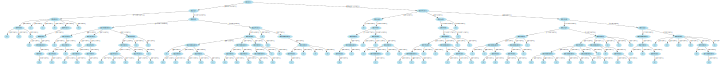

In [20]:
dot,p_max_id=show_tree(n=master_node,dot=Digraph(comment='My Tree',node_attr={'color': 'lightblue2', 'style': 'filled'}),p_max_id=0)
dot.render('titanic_before_pruning', view=True)
dot.attr(size='10')
dot

#### Testing Data accuracy

In [21]:
results=master_node.predict(df_t_cleaned[training_cols])
(sum(df_t_cleaned[target_col]==results)/len(df_t_cleaned))*100

80.86124401913875

Plotting Confusion matrix for the Testing Data:


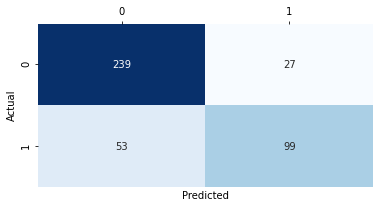

[[239, 27], [53, 99]]

In [22]:
print("Plotting Confusion matrix for the Testing Data:")
plot_confusion_matrix(df_t_cleaned[target_col],results,classes_list)

#### Training Data accuracy

In [23]:
results1=master_node.predict(df_cleaned[training_cols])
(sum(df_cleaned[target_col]==results1)/len(df_cleaned))*100

86.09550561797754

Plotting Confusion matrix for the Training Data:


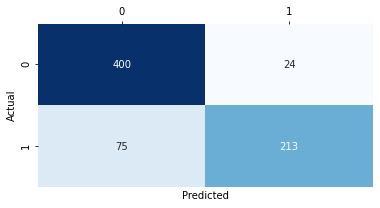

[[400, 24], [75, 213]]

In [24]:
print("Plotting Confusion matrix for the Training Data:")
plot_confusion_matrix(df_cleaned[target_col],results1,classes_list)

### Pruning

In [25]:
master_node.pruning(df_t_cleaned[training_cols],pd.DataFrame(df_t_cleaned[target_col]))

Cutting: 'ID: 4 - Parch' Node
Cutting: 'ID: 8 - Fare' Node
Cutting: 'ID: 13 - Parch' Node
Cutting: 'ID: 16 - SibSp' Node
Cutting: 'ID: 17 - SibSp' Node
Cutting: 'ID: 20 - Pclass' Node
Cutting: 'ID: 21 - Pclass' Node
Cutting: 'ID: 25 - SibSp' Node
Cutting: 'ID: 26 - SibSp' Node
Cutting: 'ID: 28 - SibSp' Node
Cutting: 'ID: 29 - SibSp' Node
Cutting: 'ID: 31 - Embarked' Node
Cutting: 'ID: 34 - Parch' Node
Cutting: 'ID: 40 - Parch' Node
Cutting: 'ID: 43 - Embarked' Node
Cutting: 'ID: 48 - Embarked' Node
Cutting: 'ID: 50 - Parch' Node
Cutting: 'ID: 55 - Parch' Node
Cutting: 'ID: 57 - Parch' Node
Cutting: 'ID: 62 - Embarked' Node
Cutting: 'ID: 64 - Parch' Node
Cutting: 'ID: 68 - Parch' Node
Cutting: 'ID: 71 - Embarked' Node
Cutting: 'ID: 7 - Embarked' Node
Cutting: 'ID: 12 - SibSp' Node
Cutting: 'ID: 15 - Parch' Node
Cutting: 'ID: 19 - SibSp' Node
Cutting: 'ID: 24 - Embarked' Node
Cutting: 'ID: 27 - Embarked' Node
Cutting: 'ID: 30 - SibSp' Node
Cutting: 'ID: 33 - SibSp' Node
Cutting: 'ID: 39 

### View the tree after Pruning

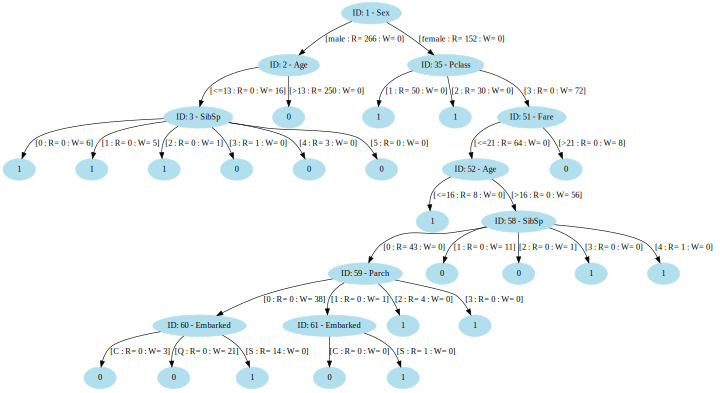

In [26]:
dot,p_max_id=show_tree(n=master_node,dot=Digraph(comment='My Tree',node_attr={'color': 'lightblue2', 'style': 'filled'}),p_max_id=0)
dot.render('titanic_after_pruning', view=True)
dot.attr(size='10')
dot

#### Testing Data accuracy after Pruning

In [27]:
results2=master_node.predict(df_t_cleaned[training_cols])
(sum(df_t_cleaned[target_col]==results2)/len(df_t_cleaned))*100

86.60287081339713

After pruning plotting Confusion matrix for the Testing Data:


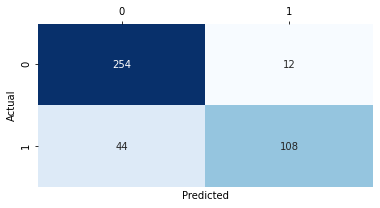

[[254, 12], [44, 108]]

In [28]:
print("After pruning plotting Confusion matrix for the Testing Data:")
plot_confusion_matrix(df_t_cleaned[target_col],results2,classes_list)

#### Training Data accuracy after Pruning

In [29]:
results3=master_node.predict(df_cleaned[training_cols])
(sum(df_cleaned[target_col]==results3)/len(df_cleaned))*100

84.5505617977528

After pruning plotting Confusion matrix for the Training Data:


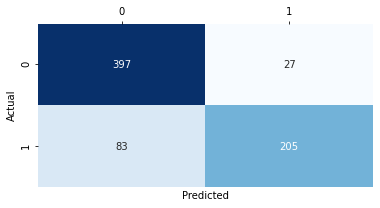

[[397, 27], [83, 205]]

In [30]:
print("After pruning plotting Confusion matrix for the Training Data:")
plot_confusion_matrix(df_cleaned[target_col],results3,classes_list)

##  References
- Analytical Information Systems course by **Prof. Dr. Gefei Zhang** at **Hochschule Hof**
    - [Link to Profile: **Prof. Dr. Gefei Zhang**](https://people.f4.htw-berlin.de/~zhangg/)
    - [Link to Course Description at **Hochschule Hof, Bavaria**](https://www.hof-university.com/graduate-school/masters-program-full-time/software-engineering-for-industrial-applications-meng.html)